In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import logit, expit
import ucscgenome

batch_size=32
input_window=256

model_path='/home/kal/CTCF/mass_CTCF/output/20170804_121119/20170804_121119_weights_3_05_46326.97.hdf5'
gen_path='/home/kal/data/ctcf_strengthgen.hdf5'
bed_path = '/home/kal/CTCF/mass_CTCF/output/20170804_121119/final_atac_scored.bed'

out_dir = os.path.dirname(model_path)

In [6]:
# load the model
model = load_model(model_path, custom_objects={'Bias':Bias})

# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# load the bed file
peaks = pd.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf pwm ml chipseq'.split()

# get the genome
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [7]:
def localize(row, verb=False):
    # break the sequence into overlapping tiles
    tile_seqs = list()
    num_tiles = int((row['end']-row['start']) / input_window) + ((row['end']-row['start']) % input_window > 0)
    if verb:
        print(num_tiles)
    for idx in range(num_tiles):
        if row['start'] + idx*input_window - input_window//2 > 0:
            seq = genome[row['chr']][row['start'] + idx*input_window - input_window//2:row['start'] + (idx+1)*input_window - input_window//2].lower()
            tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        else:
            buffered_seq = np.zeros((256,4))
            buffered_seq[:row['start'] + (idx+1)*input_window - input_window//2] = genome[row['chr']][0:row['start'] + (idx+1)*input_window - input_window//2]
            tile_seqs.append(ctcfgen.encode(np.fromstring(buffered_seq).lower(), dtype=np.uint8))
        seq = genome[row['chr']][row['start'] + idx*input_window:row['start'] + (idx+1)*input_window].lower()
        tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        
    tile_seqs= np.asarray(tile_seqs)
    tile_iter = iter(tile_seqs)
    
    # get a batch generator
    batches = ctcfgen.filled_batch(tile_iter, batch_size=batch_size)
    
    # figure out where the max prediction is coming from
    preds = list()
    for batch in batches:
        preds.append(model.predict_on_batch(batch))
    preds = np.asarray(preds).reshape((-1))[:tile_seqs.shape[0]]
    
    # get a tile centered there
    max_idx = np.argmax(preds)
    max_pred = np.max(preds)
    max_tile = batch.reshape((-1, 256, 4))[max_idx]
    if verb:
        print(max_idx)
        print(max_pred)
        print(preds)
    
    return max_tile, max_pred

In [8]:
constrained_peaks = peaks.sample(2*batch_size)
signal_seqs = list()

for index, row in constrained_peaks.iterrows():
    this_seq, max_pred = localize(row)    
    signal_seqs.append(this_seq)

constrained_peaks['signal_seq'] = signal_seqs

In [9]:
pos_peaks = peaks.loc[peaks['ctcf'] == 1]
neg_peaks = peaks.loc[peaks['ctcf'] == 0]

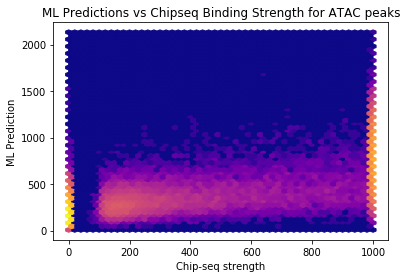

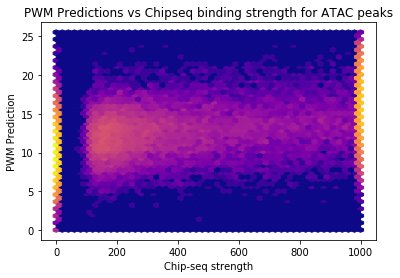

In [10]:
# does prediction value predict the biding strength? 
# make a plot of the two vs each other
plt.hexbin(peaks['chipseq'].tolist(), peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs Chipseq Binding Strength for ATAC peaks')
plt.xlabel('Chip-seq strength')
plt.ylabel('ML Prediction')
plt.show()

plt.hexbin(peaks['chipseq'].tolist(), peaks['pwm'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('PWM Predictions vs Chipseq binding strength for ATAC peaks')
plt.xlabel('Chip-seq strength')
plt.ylabel('PWM Prediction')
plt.show()

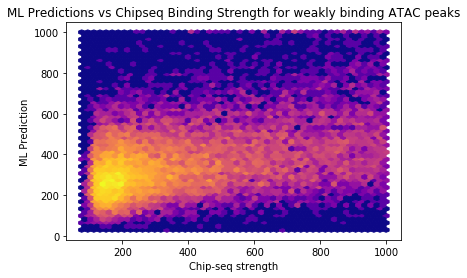

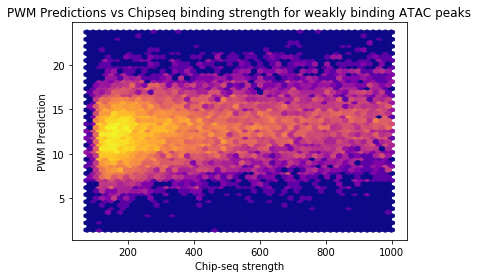

In [13]:
# focus on those not on edge of experimental detection
filter_peaks = pos_peaks.loc[(pos_peaks['chipseq'] != 1000)]
filter_peaks = filter_peaks.loc[(filter_peaks['chipseq'] != 0)]

plt.hexbin(filter_peaks['chipseq'].tolist(), np.clip(filter_peaks['ml'], None, 1000).tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs Chipseq Binding Strength for weakly binding ATAC peaks')
plt.xlabel('Chip-seq strength')
plt.ylabel('ML Prediction')
plt.show()

plt.hexbin(filter_peaks['chipseq'].tolist(), filter_peaks['pwm'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('PWM Predictions vs Chipseq binding strength for weakly binding ATAC peaks')
plt.xlabel('Chip-seq strength')
plt.ylabel('PWM Prediction')
plt.show()

In [14]:
# get an idea of how many neurons are dead -- plot ml predicition vs neuron activation
layer_name ='conv1d_1'
seqs = model.input
get_activations = K.function([seqs, K.learning_phase()], [layer_dict[layer_name].output, model.output])

g = ctcfgen.filled_batch(iter(constrained_peaks['signal_seq']), batch_size=32)

activations = list()
for i in range(2):
    input_seqs = next(g)
    a, p = get_activations([input_seqs, 0])
    both = a[:batch_size] + a[batch_size:]
    activations.append([value for value in np.max(both, axis=1)])
      
activations = [act for l in activations for act in l]
constrained_peaks['activation'] = activations

(64, 32)


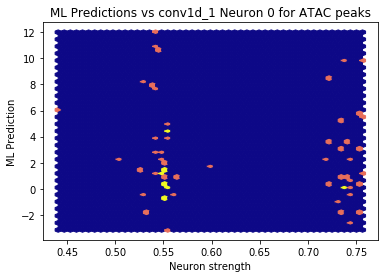

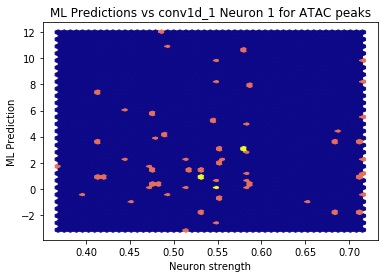

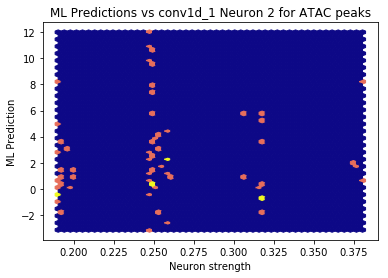

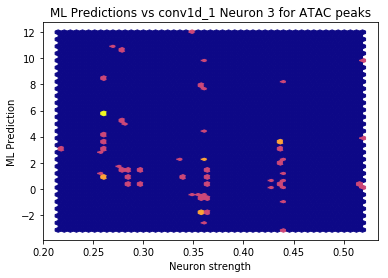

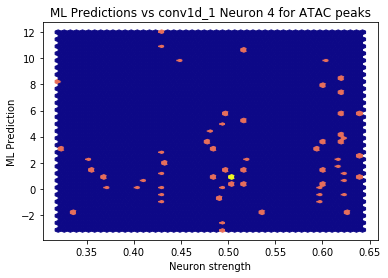

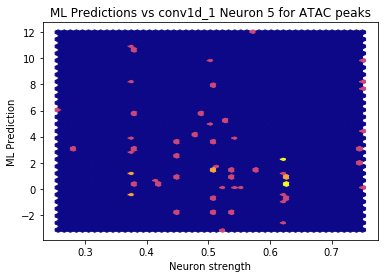

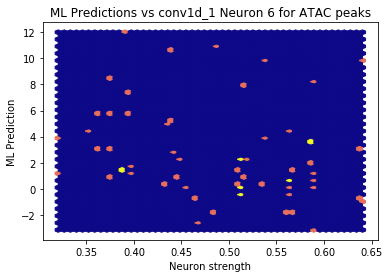

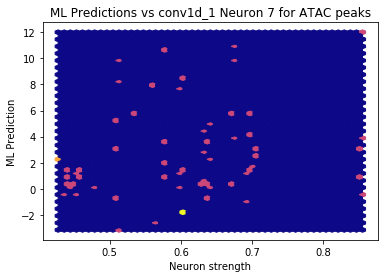

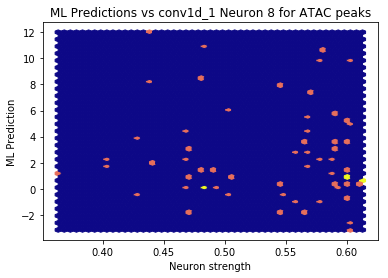

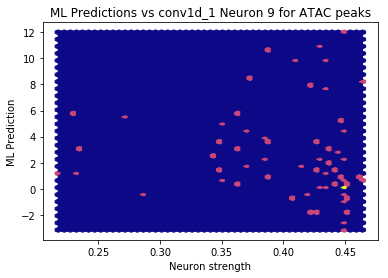

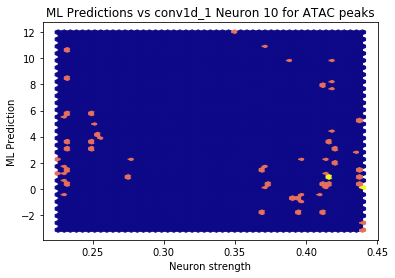

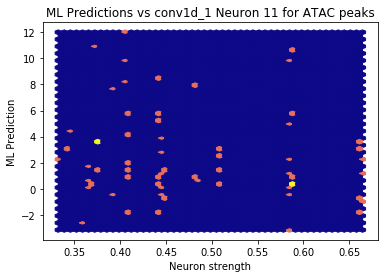

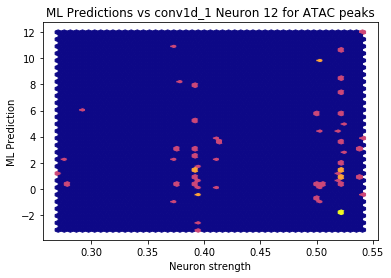

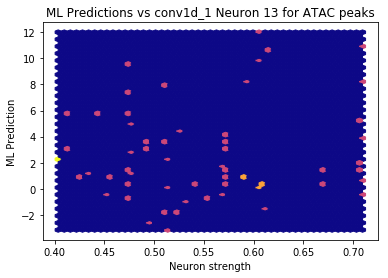

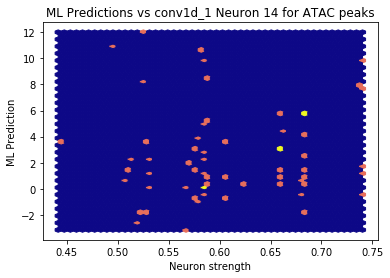

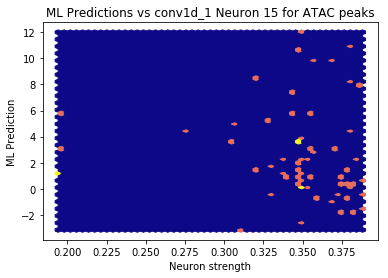

In [15]:
# neuron activation vs ml prediction
activations = np.asarray(activations)
print(activations.shape)
for filter_index in range(16):
    plt.hexbin(activations[:, filter_index], constrained_peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
    plt.title('ML Predictions vs ' + str(layer_name) + ' Neuron ' + str(filter_index) + ' for ATAC peaks')
    plt.xlabel('Neuron strength')
    plt.ylabel('ML Prediction')
    plt.show()

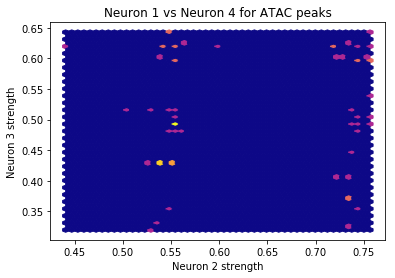

In [16]:
plt.hexbin(activations[:, 0], activations[:, 4], gridsize=50, bins='log', cmap='plasma')
plt.title('Neuron 1 vs Neuron 4 for ATAC peaks')
plt.xlabel('Neuron 2 strength')
plt.ylabel('Neuron 3 strength')
plt.show()

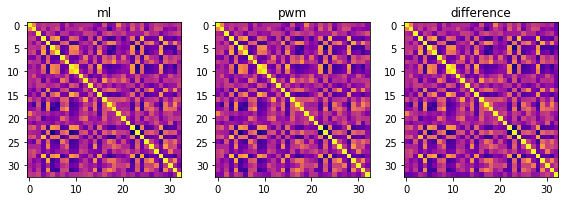

In [17]:
# plot activation covarience
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figheight(8)
f.set_figwidth(8)
#f.suptitle('Neuron-Neuron correlations for ' + str(layer_name) + ' and correlations to ml, pwm, and difference')

cov = np.corrcoef(activations, np.clip(constrained_peaks['ml'], None, 50), rowvar=False)
ax1.imshow(cov, cmap='plasma')
ax1.set_title('ml')

cov = np.corrcoef(activations, constrained_peaks['pwm'], rowvar=False)
ax2.imshow(cov, cmap='plasma')
ax2.set_title('pwm')

diff = constrained_peaks['pwm'] - np.clip(constrained_peaks['ml'], None, 50)
cov = np.corrcoef(activations, diff, rowvar=False)
ax3.imshow(cov, cmap='plasma')
ax3.set_title('difference')

plt.tight_layout()
plt.show()

(64, 38)


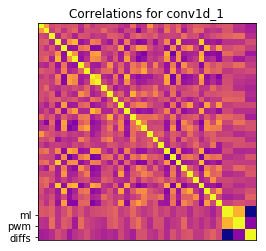

In [66]:
# plot activation covarience
plt.title('Correlations for ' + str(layer_name))

ml = np.repeat(np.expand_dims(np.clip(constrained_peaks['ml'], None, 50), axis=1), 2, axis=1)
pwm = np.repeat(np.expand_dims(constrained_peaks['pwm'], axis=1), 2, axis=1)
diff = np.repeat(np.expand_dims(constrained_peaks['pwm'] - np.clip(constrained_peaks['ml'], None, 50), axis=1), 2, axis=1)
variables = np.append(activations, ml, axis=1)
variables = np.append(variables, pwm, axis=1)
variables = np.append(variables, diff, axis=1)
label = ['ml', 'pwm', 'diffs']

cov = np.corrcoef(variables, rowvar=False)
print(variables.shape)
plt.yticks([activations.shape[1] + 1, activations.shape[1] + 3, activations.shape[1] + 5], ('ml', 'pwm', 'diffs'))
plt.xticks([])

plt.imshow(cov, cmap='plasma')
plt.show()